<a href="https://colab.research.google.com/github/etziosplay4u/Basics-of-AI-in-ML-DL/blob/main/New_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the nessesary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Declare and apply image transformations to the dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loead the Dataset and put it in the (Data Loader) loader

In [ ]:
train_dataset = datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)

# Define the hyperparameters

In [ ]:
latent_dim = 100
lr = 0.0002

# Defines the Genareator and Descriminator with it's optimizers

In [ ]:
class Gen(nn.Module):
    def __init__(self, latent_dim):
        super(Gen, self).__init__()

        self.model = nn.Sequential(
        nn.Linear(latent_dim, 128 * 8 * 8), #we took the large noise vector and made it in 128 channel with 8x8 dim to fit in the layer
        nn.ReLU(),
        nn.Unflatten(1, (128, 8, 8)), #applied unflattened to make make it a 3D tensor
        nn.Upsample(scale_factor=2), #increased the scale to generate better resolution images
        nn.Conv2d(128, 128, kernel_size=3, padding=1), # takes 128 channels and applies 128 conv filters also buts a padding of 1 around the borders to maintain the special dimension
        nn.BatchNorm2d(128, momentum=0.78), #stabilizes the training by applying batch normalization and momentum
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64, momentum=0.78),
        nn.ReLU(),
        nn.Conv2d(64, 3, kernel_size=3, padding=1),
        nn.Tanh()
)
    def forward(self, z):
        img = self.model(z)
        return img

In [ ]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), #took 3 channels and applies 32 filters
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25), #added dropouts to prevent overfitting
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)), #Added 0 padding to blank spaces casued by the stride jumps
        nn.BatchNorm2d(64, momentum=0.82), #stabilizes the training by applying batch normalization and momentum
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1), #took the large 256 vector and made it into a 4x4 dim, a single output
        nn.Sigmoid()
)

    def forward(self, img):
        validity = self.model(img)
        return validity

In [ ]:
generator = Gen(latent_dim) #generator will procuce the images from noises
discriminator = Dis()

loss_fn = nn.BCELoss()
opt_G = optim.Adam(generator.parameters(), lr=lr) #initialized the loss fuctions and optimizers
opt_D = optim.Adam(discriminator.parameters(), lr=lr)

# Initialize the training loop sequence and generate output

Epoch [1]  d_loss: 0.26  g_loss: 3.33


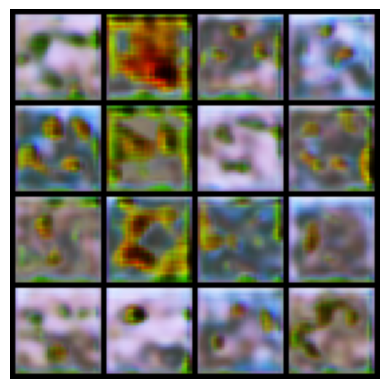

Epoch [2]  d_loss: 0.53  g_loss: 2.52


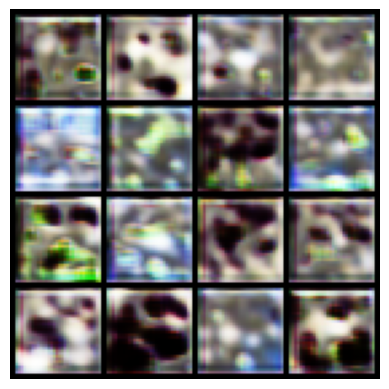

Epoch [3]  d_loss: 0.19  g_loss: 2.48


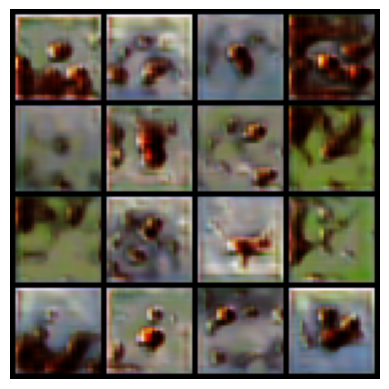

Epoch [4]  d_loss: 0.62  g_loss: 1.76


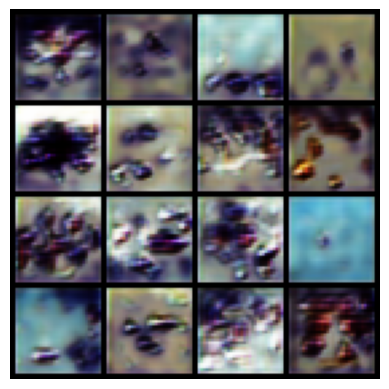

Epoch [5]  d_loss: 0.29  g_loss: 3.24


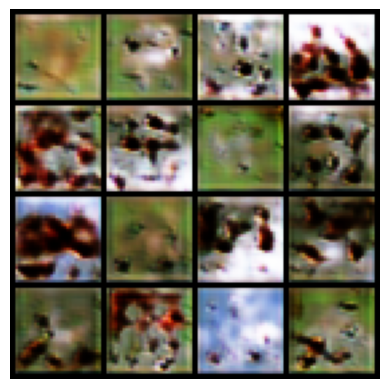

In [ ]:
epoch = 0
num_epochs = 5

while epoch < num_epochs:
    for i, (real_images, _) in enumerate(loader): #for every images from the dataloader
        batch_size = real_images.size(0)  #starts from the 1st batch (0)

        valid = torch.ones(batch_size, 1) ##created labels with valid = 1, fake = 0 initialization
        fake = torch.zeros(batch_size, 1)

        # Train Discriminator
        opt_D.zero_grad() #clears the optimizer of discr with zeros

        z = torch.randn(batch_size, latent_dim)  #generates random noise vector batches
        fake_images = generator(z) #gen makes the fake image with noise batches

        real_loss = loss_fn(discriminator(real_images), valid) #calculates loss for real images
        fake_loss = loss_fn(discriminator(fake_images.detach()), fake) #calculates loss for fake images
        d_loss = (real_loss + fake_loss) / 2  #calculates the total avg loss
        d_loss.backward()  #back propagates
        opt_D.step() #updates discr value

        # Train Generator
        opt_G.zero_grad() #clears the optimizer of gen with zeros
        gen_images = generator(z) #even though it takes the same input like the fake_images variable in discr but if i used the same variables for both of their training,
        g_loss = loss_fn(discriminator(gen_images), valid) #it would have recived gradients from the discr training and would hamper the generator's image production
        g_loss.backward()
        opt_G.step()

        if i == len(loader) - 1:
           print(f"Epoch [{epoch+1}]  d_loss: {d_loss.item():.2f}  g_loss: {g_loss.item():.2f}")

    # After the epoch, show generated images
    with torch.no_grad():
        z = torch.randn(16, latent_dim)
        generated = generator(z).detach()
        grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.show()

    epoch += 1